# Surface normals

Author(s): Jukka Aho

**Abstract**: Testing different strategies to calculate surface normals. These are important when calculating mortar projections.

In [1]:
using JuliaFEM
using JuliaFEM: Element, get_connectivity, get_field, set_field
using JuliaFEM: get_number_of_basis_functions, get_detJ, get_basis
using JuliaFEM: interpolate, dinterpolate, get_dbasisdxi, new_field!, push_field!, PSeg
using JuliaFEM: set_degree, get_number_of_basis_functions, dinterpolate
using ForwardDiff
using PyPlot

In [2]:
phi = linspace(pi, 0, 4)
nelements = length(phi)-1
nnodes = length(phi)
elements = []
R = 10.0
for i=1:nelements
    con = [i, mod(i, nnodes)+1]
    seg = PSeg(con)
    # create vector field :geometry for elements
    pnts = Vector[]
    for deg in phi[con]
        X = R*[cos(deg), sin(deg)]
        push!(pnts, X)
    end
    set_field(seg, :Geometry, pnts)
    push!(elements, seg)
end
elements

3-element Array{Any,1}:
 JuliaFEM.PSeg([1,2],Dict{Any,Any}(:Geometry=>Array{T,1}[[-10.0,1.2246467991473533e-15],[-4.999999999999998,8.660254037844387]]),1)       
 JuliaFEM.PSeg([2,3],Dict{Any,Any}(:Geometry=>Array{T,1}[[-4.999999999999998,8.660254037844387],[5.000000000000001,8.660254037844386]]),1)
 JuliaFEM.PSeg([3,4],Dict{Any,Any}(:Geometry=>Array{T,1}[[5.000000000000001,8.660254037844386],[10.0,0.0]]),1)                            

In [3]:
# calculate "local" normals in elements, in a way that
# n = Nᵢnᵢ gives some reasonable results for ξ ∈ [-1, 1]

function calculate_normals!(el::Element, field_name=:Normals)
    new_field!(el, field_name, Vector)
    for xi in Vector[[-1.0], [1.0]]
        t = dinterpolate(el, :Geometry, xi)
        n = [0 -1; 1 0]*t
        n /= norm(n)
        push_field!(el, field_name, n)
    end
end

for el in elements
    calculate_normals!(el)
end

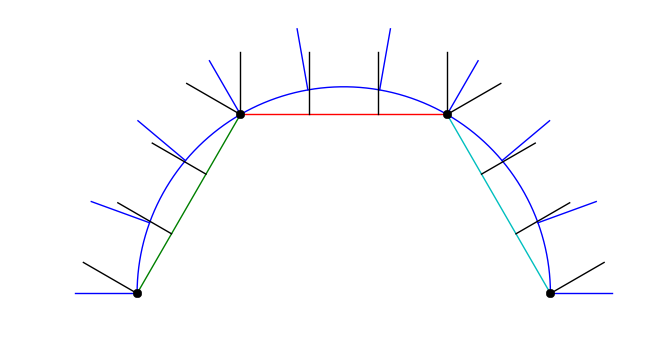

(-15.0,15.0,-2.0,14.0)

In [4]:
function plot_stuff(elements)
    phi2 = linspace(0, pi, 100)
    phi3 = linspace(0, pi, 10)
    phi4 = linspace(0, pi, 4)
    figure(figsize=(8, 4))
    plot(R*cos(phi2), R*sin(phi2))
    for fi in phi3
        p0 = R*[cos(fi), sin(fi)]
        p1 = (R+3)*[cos(fi), sin(fi)]
        plot([p0[1], p1[1]], [p0[2], p1[2]], "-b")
    end

    # create a array of vectors
    xis = Vector[[xi] for xi in linspace(-1, 1)]
    for el in elements
        coords = interpolate(el, :Geometry, xis)
        # extract 1 and 2 components from array of coordinates
        xs = [X[1] for X in coords]
        ys = [X[2] for X in coords]
        plot(xs, ys, "-")
    end

    xis = Vector[[xi] for xi in linspace(-1, 1, 4)]
    for el in elements
        coords = interpolate(el, :Geometry, xis)
        normals = interpolate(el, :Normals, xis)
        for i=1:length(normals)
            p0 = coords[i]
            p1 = coords[i] + normals[i]/norm(normals[i])*3
            plot([p0[1], p1[1]], [p0[2], p1[2]], "-k")
        end
    end
    plot(R*cos(phi4), R*sin(phi4), "ko")

    xlim(-1.5*R, 1.5*R)
    ylim(-0.5*R, 1.5*R)

    axis("equal")
    axis("off")
end

plot_stuff(elements)

Blue lines "accurate" normal direction, other lines are approximations. Notice the discontinuity in the nodes.

## Strategy 1

average normals of adjacent elements in common nodes, maybe by weighting it with areas / lenghts ...

In [5]:
"""
Alter normal field such that normals of adjacent elements are averaged.
"""
function average_normals!(elements, normal_field=:Normals)
    d = Dict()
    for el in elements
        c = get_connectivity(el)
        n = get_field(el, normal_field)
        for (ci, ni) in zip(c, n)
            d[ci] = haskey(d, ci) ? d[ci] + ni : ni
        end
    end
    for (ci, ni) in d
        d[ci] /= norm(d[ci])
    end
    for el in elements
        c = get_connectivity(el)
        new_normals = [d[ci] for ci in c]
        set_field(el, normal_field, new_normals)
    end
end
average_normals!(elements)

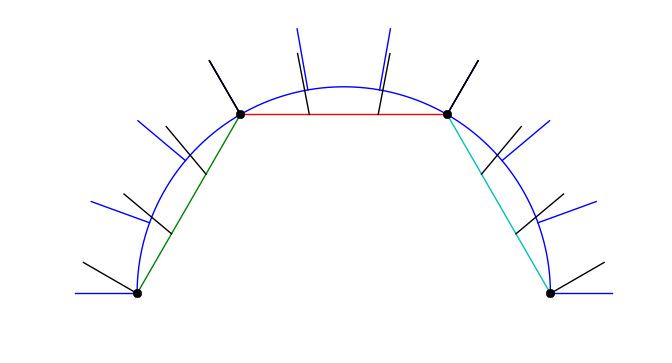

(-15.0,15.0,-2.0,14.0)

In [6]:
plot_stuff(elements)

A little better, now the interpolant of normal field is continuous.

## Strategy 2

Fit field. Here we define normal function and fit field for that. This of course require us to know what is the normal field, in this case it's easily defined $f(x) = X_1^2 + X_2^2 - 10^2$.

In [7]:
"""
Fit field s.t. || ∫ (Nᵢ(ξ)αᵢ - f(el, ξ)) dS || -> min!
"""
function fit_field!(el::Element, field, f, fixed_coeffs=Int[])
    w = [
        128/225,
        (332+13*sqrt(70))/900,
        (332+13*sqrt(70))/900,
        (332-13*sqrt(70))/900,
        (332-13*sqrt(70))/900]
    xi = Vector[
        [0.0],
        [ 1/3*sqrt(5 - 2*sqrt(10/7))],
        [-1/3*sqrt(5 - 2*sqrt(10/7))], 
        [ 1/3*sqrt(5 + 2*sqrt(10/7))],
        [-1/3*sqrt(5 + 2*sqrt(10/7))]]
    n = get_number_of_basis_functions(el)
    fld = get_field(el, field)
    nfld = length(fld[1])
    #Logging.debug("dim of field $field: $nfld")

    M = zeros(n, n)
    b = zeros(n, nfld)
    for i=1:length(w)
        detJ = get_detJ(el, xi[i])
        N = get_basis(el, xi[i])
        M += w[i]*N*N'*detJ
        fi = f(el, xi[i])
        for j=1:nfld
            b[:, j] += w[i]*N*fi[j]*detJ
        end
    end

    coeffs = zeros(n)
    for j=1:nfld
        for k=1:n
            coeffs[k] = fld[k][j]
        end
        if length(fixed_coeffs) != 0
            # constrained problem, some coefficients are fixed
            N = Int[] # rest of coeffs
            S = Int[] # fixed coeffs
            for i = 1:n
                if i in fixed_coeffs
                    push!(S, i)
                else
                    push!(N, i)
                end
            end
            lhs = M[N,N]
            rhs = b[N,j] - M[N,S]*coeffs[S]
            coeffs[N] = lhs \ rhs
        else
            coeffs[:] = M \ b[:,j]
        end
        for k=1:n
            fld[k][j] = coeffs[k]
        end
    end
    set_field(el, field, fld)
    return
end

fit_field! (generic function with 2 methods)

In [8]:
"""
Return accurate normal for element based on a known geometry.
"""
function f(el, xi)
    geom_info(X) = X[1]^2 + X[2]^2 - 10^2
    X = interpolate(el, :Geometry, xi)
    n = ForwardDiff.gradient(geom_info, X)
    n / norm(n)
end

f (generic function with 1 method)

In [9]:
for el in elements
    fit_field!(el, :Normals, f)
end

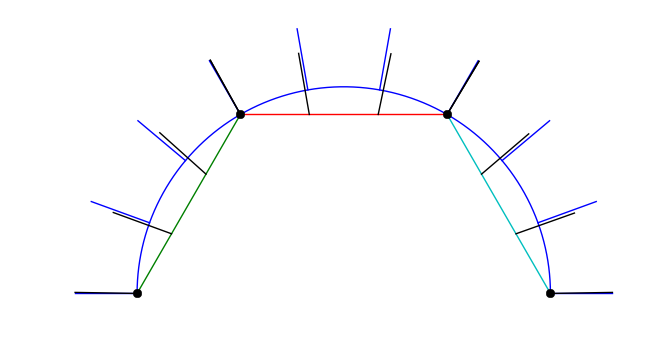

(-15.0,15.0,-2.0,14.0)

In [10]:
plot_stuff(elements)

Normal direction fitted in least squares sense. Getting better all the time. Now the field is accurate in nodal points and quite close in all around the faceted surface. Why not also fit geometry based on normal direction information? Let's increase the degree of approximation by introducing new basis function to hierarchical basis and use that to get more accurate solution:

In [11]:
for el in elements
    set_degree(el, 2)
    for field in (:Geometry, :Normals)
        push!(el.fields[field], [0.0, 0.0])
        el.fields[field] = el.fields[field][1:get_number_of_basis_functions(el)]
    end
end

In [12]:
"""
Fit field s.t. || ∫ ∂/∂ξ(∑Nᵢ(ξ)αᵢ)f(el, ξ) dS || -> min!
"""
function fit_derivative_field!(el::Element, field, f, fixed_coeffs=Int[])
    w = [
        128/225,
        (332+13*sqrt(70))/900,
        (332+13*sqrt(70))/900,
        (332-13*sqrt(70))/900,
        (332-13*sqrt(70))/900]
    xi = Vector[
        [0.0],
        [ 1/3*sqrt(5 - 2*sqrt(10/7))],
        [-1/3*sqrt(5 - 2*sqrt(10/7))], 
        [ 1/3*sqrt(5 + 2*sqrt(10/7))],
        [-1/3*sqrt(5 + 2*sqrt(10/7))]]
    n = get_number_of_basis_functions(el)
    fld = get_field(el, field)
    nfld = length(fld[1])
    #Logging.debug("dim of field $field: $nfld")

    M = zeros(n, n)
    b = zeros(n, nfld)
    for i=1:length(w)
        detJ = get_detJ(el, xi[i])
        dNdxi = get_dbasisdxi(el, xi[i])
        dNdX = dNdxi / detJ
        M += w[i]*dNdX*dNdX'*detJ
        fi = f(el, xi[i])
        for j=1:nfld
            b[:, j] += w[i]*dNdX*fi[j]*detJ
        end
    end

    coeffs = zeros(n)
    for j=1:nfld
        for k=1:n
            coeffs[k] = fld[k][j]
        end
        if length(fixed_coeffs) != 0
            #Logging.info("constrained problem, some coefficients are fixed")
            N = Int[] # rest of coeffs
            S = Int[] # fixed coeffs
            for i = 1:n
                if i in fixed_coeffs
                    push!(S, i)
                else
                    push!(N, i)
                end
            end
            lhs = M[N,N]
            rhs = b[N,j] - M[N,S]*coeffs[S]
            coeffs[N] = lhs \ rhs
        else
            coeffs[:] = M \ b[:,j]
        end
        for k=1:n
            fld[k][j] = coeffs[k]
        end
    end
    set_field(el, field, fld)
    return
end

fit_derivative_field! (generic function with 2 methods)

In [13]:
"""
Return tangent vector in point ξ for element el.
"""
function tangent(el, xi)
    normal = interpolate(el, :Normals, xi)
    [0 -1; 1 0]'*normal
end

for i=1:5
    for el in elements
        fit_field!(el, :Normals, f)
        fit_derivative_field!(el, :Geometry, tangent, Int[1, 2])
    end
end

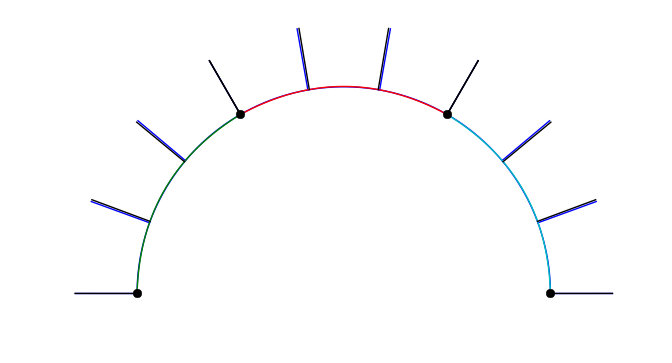

(-15.0,15.0,-2.0,14.0)

In [14]:
plot_stuff(elements)

Remark: we didn't use accurate geometry information in any phase to fix geometry.